### 1.Load Libraries

In [30]:
#!pip install imbalanced-learn --user

In [5]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, hamming_loss
import warnings
import random
import matplotlib.pyplot as plt
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import *
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import *
import pandas as pd
import numpy as np
import scipy
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from tqdm.notebook import tqdm
import time
tqdm.pandas()

%matplotlib inline
params = {'legend.fontsize': 'x-large',
          'axes.labelsize': 'x-large',
          'axes.titlesize': 'x-large',
          'xtick.labelsize': 'x-large',
          'ytick.labelsize': 'x-large'}
plt.rcParams.update(params)

warnings.filterwarnings('ignore')
random.seed(2021)
np.random.seed(2021)

### 2.Load Data

In [6]:
data = pd.read_csv(r'C:\Users\admin\Desktop\Project\Data\Data 1\final_review.csv')
data.head(3)

,verified,review_text,helpfulVotes,rating,clean_text,clean_text_tokenized,clean_text_without_stopwords,clean_text_tokenized_join_text,total_text_len,polarity,subjectivity
0,False,"Def not best, but not worst I had the Samsung ...",1.0,3,def not best but not worst i had the samsung a...,"['def', 'not', 'best', 'but', 'not', 'worst', ...","['def', 'best', 'worst', 'samsung', 'a600', 'a...",def best worst samsung a600 awhile absolute do...,171,0.115527,0.554326
1,False,Text Messaging Doesn't Work Due to a software ...,17.0,1,text messaging doesnt work due to a software i...,"['text', 'messaging', 'doesnt', 'work', 'due',...","['text', 'messaging', 'doesnt', 'work', 'due',...",text messaging doesnt work due software issue ...,73,0.109722,0.393056
2,False,"Love This Phone This is a great, reliable phon...",5.0,5,love this phone this is a great reliable phone...,"['love', 'this', 'phone', 'this', 'is', 'a', '...","['love', 'phone', 'great', 'reliable', 'phone'...",love phone great reliable phone also purchased...,74,0.313095,0.590018


### 3.Drop the Missing Values

In [7]:
total_rows = data.shape[0]
data = data[~data['clean_text_tokenized_join_text'].isna()]
rows_after_dropna = data.shape[0]
print(f"Total rows Dropped: {total_rows - rows_after_dropna}")


Total rows Dropped: 42


### 4.Convert target class into 3 major classes

In [8]:
# Convert target class from (1 to 5) to (1 to 3)
def get_reduced_target(target_class):
    if target_class <= 2:
        return 1 # Negative
    elif target_class == 3:
        return 2 # Neutral
    else:
        return 3 # Positive


data['rating'] = data['rating'].progress_apply(lambda x: get_reduced_target(x))

  0%|          | 0/67944 [00:00<?, ?it/s]

### 5.Split the data into X and y

In [9]:
X = data['clean_text_tokenized_join_text'].values
y = data['rating'].values

### 6.Apply tf-idf to the text

In [10]:
tfidf = TfidfVectorizer()
X = tfidf.fit_transform(X)

In [11]:
X.shape

(67944, 49033)

### 7.Split the data into train and test

In [13]:
X_train = X[:49999]
y_train = y[:49999]
X_test = X[50000:]
y_test = y[50000:]

### 8.Train the model
#### 8.1.Logistic Regression without Class Imbalance

Cohen Kappa Score: 68.11181849053638
              precision    recall  f1-score   support

           1       0.74      0.84      0.79      3179
           2       0.42      0.07      0.12      1088
           3       0.93      0.96      0.94     13677

    accuracy                           0.88     17944
   macro avg       0.70      0.62      0.62     17944
weighted avg       0.86      0.88      0.87     17944

                   pre       rec       spe        f1       geo       iba       sup

          1       0.74      0.84      0.94      0.79      0.89      0.78      3179
          2       0.42      0.07      0.99      0.12      0.26      0.06      1088
          3       0.93      0.96      0.76      0.94      0.85      0.74     13677

avg / total       0.86      0.88      0.80      0.87      0.82      0.71     17944



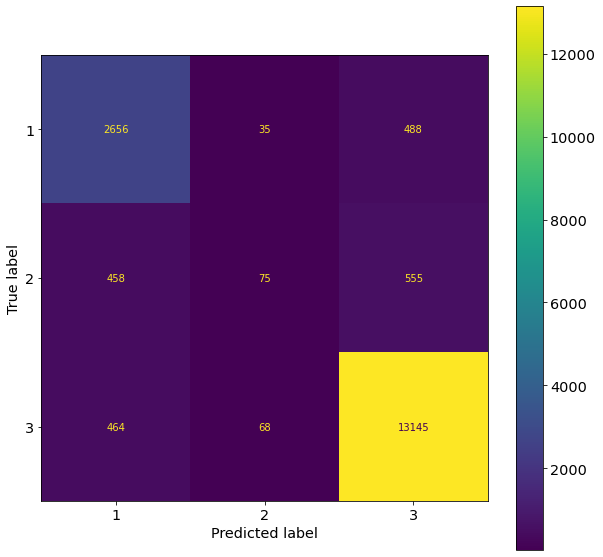

In [14]:

from sklearn.metrics import ConfusionMatrixDisplay
from imblearn.metrics import classification_report_imbalanced

clf_lr = LogisticRegression(multi_class="multinomial")
clf_lr.fit(X_train, y_train)
predictions = clf_lr.predict(X_test)

print("Cohen Kappa Score:", cohen_kappa_score(y_test, predictions) * 100)
print(classification_report(y_test, predictions))
print(classification_report_imbalanced(y_test, predictions))

cm = confusion_matrix(y_test, predictions, labels=clf_lr.classes_)
fig, ax = plt.subplots(figsize=(10, 10))
disp = ConfusionMatrixDisplay(
    confusion_matrix=cm, display_labels=clf_lr.classes_)
disp.plot(ax=ax)
plt.show()


#### 8.2.Logistic Regression with Class Imbalance

In [31]:
#!pip install delayed

In [15]:
from collections import Counter
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE, ADASYN
from imblearn.over_sampling import BorderlineSMOTE

ros = SMOTE(random_state=42)
X_resampled, y_resampled = ros.fit_resample(X_train, y_train)
print(sorted(Counter(y_resampled).items()))

[(1, 32867), (2, 32867), (3, 32867)]


Cohen Kappa Score: 57.803004748876276
              precision    recall  f1-score   support

           1       0.69      0.77      0.73      3179
           2       0.20      0.42      0.27      1088
           3       0.96      0.86      0.91     13677

    accuracy                           0.81     17944
   macro avg       0.62      0.68      0.64     17944
weighted avg       0.87      0.81      0.84     17944

                   pre       rec       spe        f1       geo       iba       sup

          1       0.69      0.77      0.93      0.73      0.84      0.70      3179
          2       0.20      0.42      0.89      0.27      0.61      0.36      1088
          3       0.96      0.86      0.90      0.91      0.88      0.76     13677

avg / total       0.87      0.81      0.90      0.84      0.85      0.73     17944



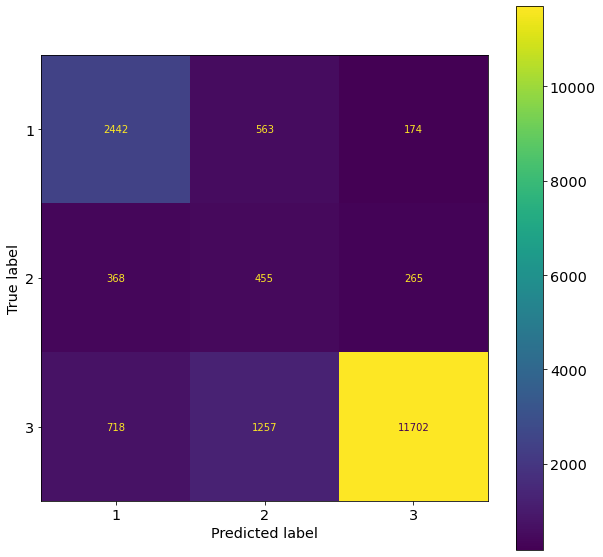

In [16]:
from imblearn.metrics import classification_report_imbalanced
clf_lr = LogisticRegression(multi_class="multinomial")
clf_lr.fit(X_resampled, y_resampled)
# print prediction results
predictions = clf_lr.predict(X_test)
print("Cohen Kappa Score:", cohen_kappa_score(y_test, predictions) * 100)
print(classification_report(y_test, predictions))
print(classification_report_imbalanced(y_test, predictions))

cm = confusion_matrix(y_test, predictions, labels=clf_lr.classes_)
fig, ax = plt.subplots(figsize=(10, 10))
disp = ConfusionMatrixDisplay(
    confusion_matrix=cm, display_labels=clf_lr.classes_)
disp.plot(ax=ax)

plt.show()

#### 8.3.MultiNomialNB

Cohen Kappa Score: 51.56263877873673
              precision    recall  f1-score   support

           1       0.85      0.55      0.67      3179
           2       0.00      0.00      0.00      1088
           3       0.85      0.99      0.92     13677

    accuracy                           0.85     17944
   macro avg       0.57      0.51      0.53     17944
weighted avg       0.80      0.85      0.82     17944

                   pre       rec       spe        f1       geo       iba       sup

          1       0.85      0.55      0.98      0.67      0.73      0.52      3179
          2       0.00      0.00      1.00      0.00      0.00      0.00      1088
          3       0.85      0.99      0.45      0.92      0.67      0.47     13677

avg / total       0.80      0.85      0.58      0.82      0.64      0.45     17944



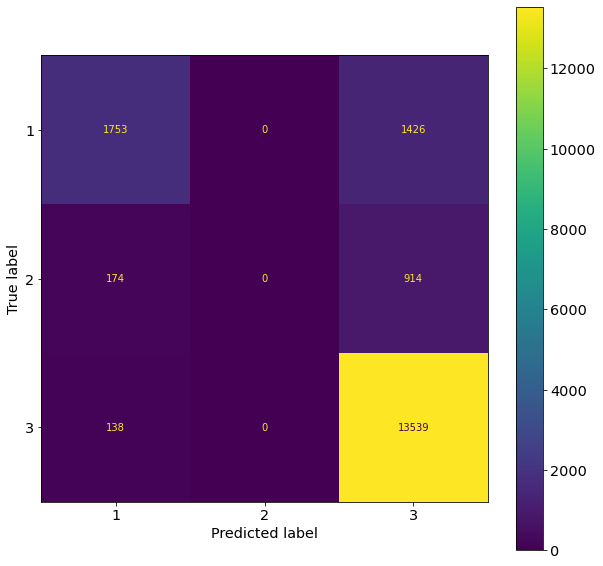

In [17]:
clf_multinb = MultinomialNB()
clf_multinb.fit(X_train, y_train)
predictions = clf_multinb.predict(X_test)
print("Cohen Kappa Score:", cohen_kappa_score(y_test, predictions) * 100)
print(classification_report(y_test, predictions))
print(classification_report_imbalanced(y_test, predictions))

cm = confusion_matrix(y_test, predictions, labels=clf_multinb.classes_)
fig, ax = plt.subplots(figsize=(10, 10))
disp = ConfusionMatrixDisplay(
    confusion_matrix=cm, display_labels=clf_multinb.classes_)
disp.plot(ax=ax)

plt.show()


#### 8.4.MultiNomial NB without Class Imbalance

Cohen Kappa Score: 54.65937709596298
              precision    recall  f1-score   support

           1       0.72      0.72      0.72      3179
           2       0.19      0.53      0.27      1088
           3       0.97      0.83      0.89     13677

    accuracy                           0.79     17944
   macro avg       0.63      0.69      0.63     17944
weighted avg       0.88      0.79      0.82     17944

                   pre       rec       spe        f1       geo       iba       sup

          1       0.72      0.72      0.94      0.72      0.82      0.67      3179
          2       0.19      0.53      0.85      0.27      0.67      0.44      1088
          3       0.97      0.83      0.92      0.89      0.87      0.75     13677

avg / total       0.88      0.79      0.92      0.82      0.85      0.72     17944



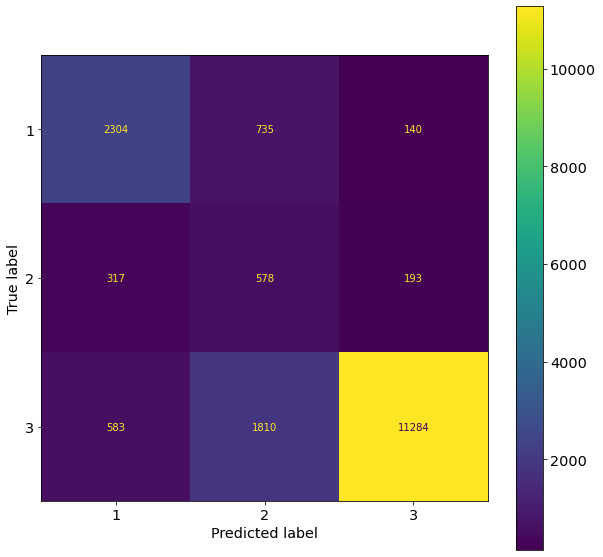

In [18]:
clf_multinb = MultinomialNB()
clf_multinb.fit(X_resampled, y_resampled)
# print prediction results
predictions = clf_multinb.predict(X_test)
print("Cohen Kappa Score:", cohen_kappa_score(y_test, predictions) * 100)
print(classification_report(y_test, predictions))
print(classification_report_imbalanced(y_test, predictions))

cm = confusion_matrix(y_test, predictions, labels=clf_multinb.classes_)
fig, ax = plt.subplots(figsize=(10, 10))
disp = ConfusionMatrixDisplay(
    confusion_matrix=cm, display_labels=clf_multinb.classes_)
disp.plot(ax=ax)
plt.show()


#### 8.5.Ensemble Learning using Voting Classifier

In [19]:
from sklearn.ensemble import VotingClassifier

##### 8.5.1.Hard Classifier

Cohen Kappa Score: 68.33061549428493
              precision    recall  f1-score   support

           1       0.74      0.84      0.79      3179
           2       0.42      0.07      0.11      1088
           3       0.93      0.96      0.94     13677

    accuracy                           0.89     17944
   macro avg       0.70      0.62      0.61     17944
weighted avg       0.86      0.89      0.87     17944

                   pre       rec       spe        f1       geo       iba       sup

          1       0.74      0.84      0.94      0.79      0.89      0.78      3179
          2       0.42      0.07      0.99      0.11      0.25      0.06      1088
          3       0.93      0.96      0.76      0.94      0.85      0.75     13677

avg / total       0.86      0.89      0.81      0.87      0.82      0.71     17944



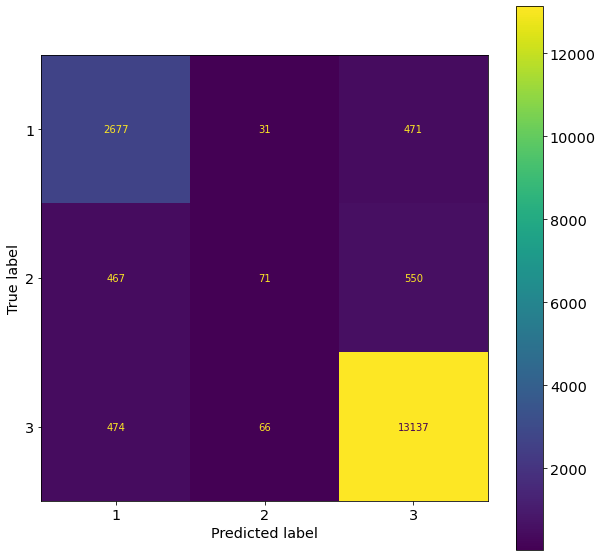

In [20]:
clf1 = LogisticRegression(multi_class="multinomial")
clf2 = MultinomialNB()

eclf1 = VotingClassifier(
    estimators=[('lr', clf1), ('mnb', clf2)], voting='hard')

eclf1.fit(X_train, y_train)
predictions = eclf1.predict(X_test)
print("Cohen Kappa Score:", cohen_kappa_score(y_test, predictions) * 100)
print(classification_report(y_test, predictions))
print(classification_report_imbalanced(y_test, predictions))

cm = confusion_matrix(y_test, predictions, labels=eclf1.classes_)
fig, ax = plt.subplots(figsize=(10, 10))
disp = ConfusionMatrixDisplay(
    confusion_matrix=cm, display_labels=eclf1.classes_)
disp.plot(ax=ax)

plt.show()


##### 8.5.2.Hard Classifier with Class Imbalance

Cohen Kappa Score: 53.02248657168691
              precision    recall  f1-score   support

           1       0.66      0.83      0.73      3179
           2       0.17      0.46      0.25      1088
           3       0.98      0.78      0.87     13677

    accuracy                           0.77     17944
   macro avg       0.60      0.69      0.62     17944
weighted avg       0.87      0.77      0.81     17944

                   pre       rec       spe        f1       geo       iba       sup

          1       0.66      0.83      0.91      0.73      0.87      0.74      3179
          2       0.17      0.46      0.85      0.25      0.63      0.38      1088
          3       0.98      0.78      0.95      0.87      0.86      0.73     13677

avg / total       0.87      0.77      0.93      0.81      0.85      0.71     17944



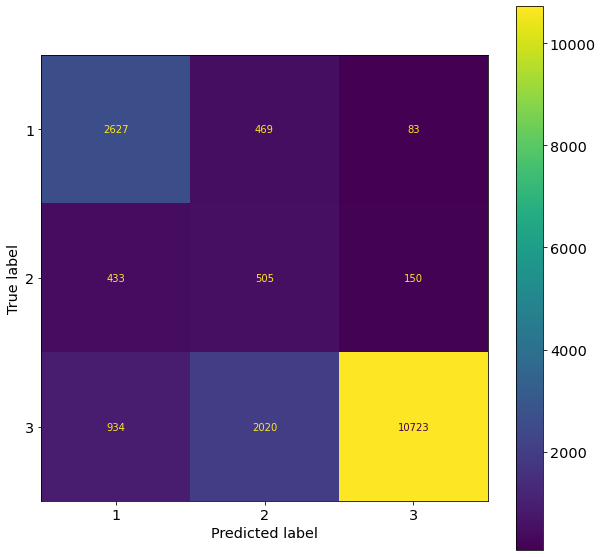

In [21]:
clf1 = LogisticRegression(multi_class="multinomial")
clf2 = MultinomialNB()

eclf1 = VotingClassifier(
    estimators=[('lr', clf1), ('mnb', clf2)], voting='hard')

eclf1.fit(X_resampled, y_resampled)
predictions = eclf1.predict(X_test)
print("Cohen Kappa Score:", cohen_kappa_score(y_test, predictions) * 100)
print(classification_report(y_test, predictions))
print(classification_report_imbalanced(y_test, predictions))

cm = confusion_matrix(y_test, predictions, labels=eclf1.classes_)
fig, ax = plt.subplots(figsize=(10, 10))
disp = ConfusionMatrixDisplay(
    confusion_matrix=cm, display_labels=eclf1.classes_)
disp.plot(ax=ax)

plt.show()


##### 8.5.3.Soft Classifier

Cohen Kappa Score: 63.85983959127637
              precision    recall  f1-score   support

           1       0.80      0.74      0.77      3179
           2       0.50      0.00      0.01      1088
           3       0.89      0.98      0.94     13677

    accuracy                           0.88     17944
   macro avg       0.73      0.58      0.57     17944
weighted avg       0.85      0.88      0.85     17944

                   pre       rec       spe        f1       geo       iba       sup

          1       0.80      0.74      0.96      0.77      0.84      0.70      3179
          2       0.50      0.00      1.00      0.01      0.06      0.00      1088
          3       0.89      0.98      0.63      0.94      0.79      0.64     13677

avg / total       0.85      0.88      0.71      0.85      0.75      0.61     17944



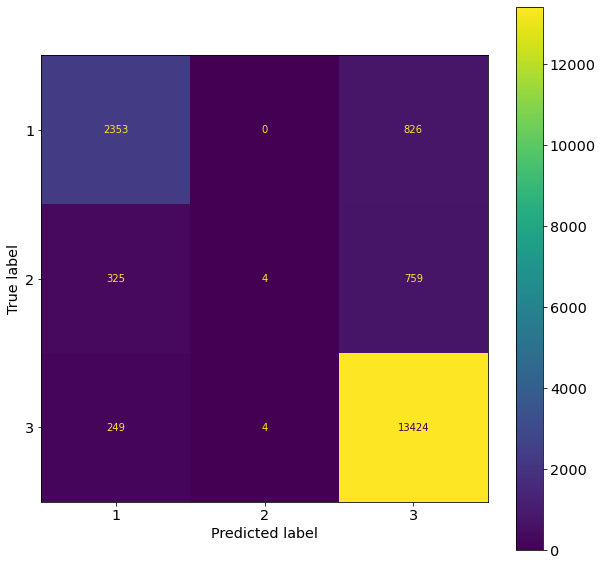

In [22]:
clf1 = LogisticRegression(multi_class="multinomial")
clf2 = MultinomialNB()

eclf2 = VotingClassifier(
    estimators=[('lr', clf1), ('mnb', clf2)], voting='soft')

eclf2.fit(X_train, y_train)
predictions = eclf2.predict(X_test)
print("Cohen Kappa Score:", cohen_kappa_score(y_test, predictions) * 100)
print(classification_report(y_test, predictions))
print(classification_report_imbalanced(y_test, predictions))

cm = confusion_matrix(y_test, predictions, labels=eclf2.classes_)
fig, ax = plt.subplots(figsize=(10, 10))
disp = ConfusionMatrixDisplay(
    confusion_matrix=cm, display_labels=eclf2.classes_)
disp.plot(ax=ax)

plt.show()


##### 8.5.4.Soft Classification with Class ImBalance

Cohen Kappa Score: 59.02527021150845
              precision    recall  f1-score   support

           1       0.72      0.76      0.74      3179
           2       0.21      0.47      0.29      1088
           3       0.97      0.86      0.91     13677

    accuracy                           0.82     17944
   macro avg       0.63      0.70      0.65     17944
weighted avg       0.88      0.82      0.84     17944

                   pre       rec       spe        f1       geo       iba       sup

          1       0.72      0.76      0.94      0.74      0.84      0.70      3179
          2       0.21      0.47      0.89      0.29      0.64      0.40      1088
          3       0.97      0.86      0.91      0.91      0.88      0.78     13677

avg / total       0.88      0.82      0.91      0.84      0.86      0.74     17944



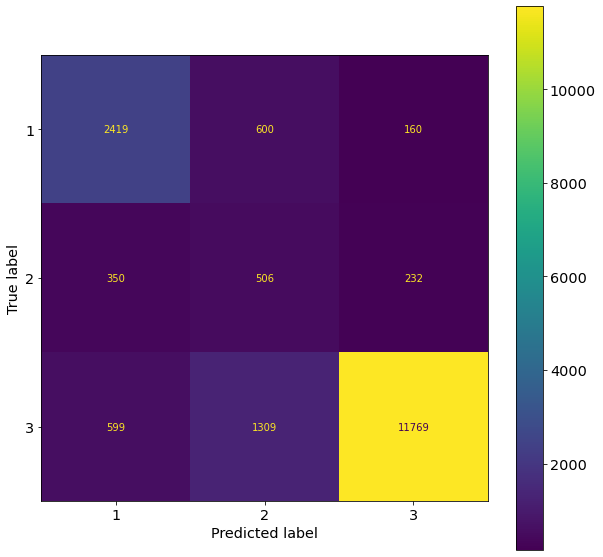

In [23]:
clf1 = LogisticRegression(multi_class="multinomial")
clf2 = MultinomialNB()

eclf2 = VotingClassifier(
    estimators=[('lr', clf1), ('mnb', clf2)], voting='soft')

eclf2.fit(X_resampled, y_resampled)
predictions = eclf2.predict(X_test)
print("Cohen Kappa Score:", cohen_kappa_score(y_test, predictions) * 100)
print(classification_report(y_test, predictions))
print(classification_report_imbalanced(y_test, predictions))

cm = confusion_matrix(y_test, predictions, labels=eclf2.classes_)
fig, ax = plt.subplots(figsize=(10, 10))
disp = ConfusionMatrixDisplay(
    confusion_matrix=cm, display_labels=eclf2.classes_)
disp.plot(ax=ax)

plt.show()

##### 8.5.5.Hard Classifier with Weighted Average

Cohen Kappa Score: 68.11181849053638
              precision    recall  f1-score   support

           1       0.74      0.84      0.79      3179
           2       0.42      0.07      0.12      1088
           3       0.93      0.96      0.94     13677

    accuracy                           0.88     17944
   macro avg       0.70      0.62      0.62     17944
weighted avg       0.86      0.88      0.87     17944

                   pre       rec       spe        f1       geo       iba       sup

          1       0.74      0.84      0.94      0.79      0.89      0.78      3179
          2       0.42      0.07      0.99      0.12      0.26      0.06      1088
          3       0.93      0.96      0.76      0.94      0.85      0.74     13677

avg / total       0.86      0.88      0.80      0.87      0.82      0.71     17944



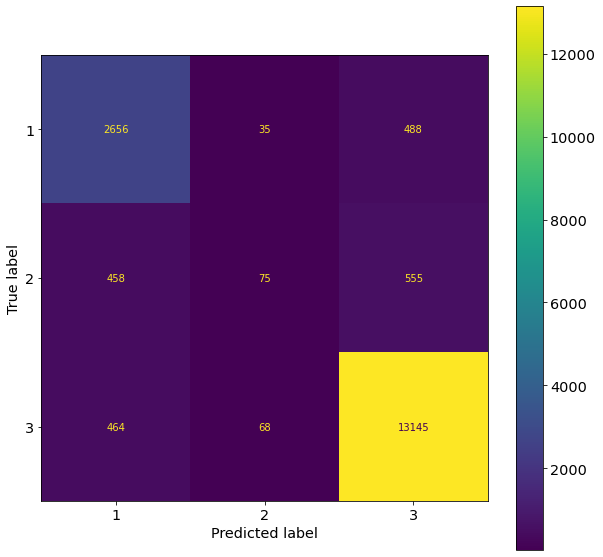

In [24]:
clf1 = LogisticRegression(multi_class="multinomial")
clf2 = MultinomialNB()

eclf3 = VotingClassifier(estimators=[('lr', clf1), ('mnb', clf2)], voting='hard', 
                         weights=[2, 1], flatten_transform=True)

eclf3.fit(X_train, y_train)
predictions = eclf3.predict(X_test)
print("Cohen Kappa Score:", cohen_kappa_score(y_test, predictions) * 100)
print(classification_report(y_test, predictions))
print(classification_report_imbalanced(y_test, predictions))

cm = confusion_matrix(y_test, predictions, labels=eclf3.classes_)
fig, ax = plt.subplots(figsize=(10, 10))
disp = ConfusionMatrixDisplay(
    confusion_matrix=cm, display_labels=eclf3.classes_)
disp.plot(ax=ax)

plt.show()


##### 8.5.6.Hard Classifier with weighted Averaging and Class Imbalance

Cohen Kappa Score: 57.803004748876276
              precision    recall  f1-score   support

           1       0.69      0.77      0.73      3179
           2       0.20      0.42      0.27      1088
           3       0.96      0.86      0.91     13677

    accuracy                           0.81     17944
   macro avg       0.62      0.68      0.64     17944
weighted avg       0.87      0.81      0.84     17944

                   pre       rec       spe        f1       geo       iba       sup

          1       0.69      0.77      0.93      0.73      0.84      0.70      3179
          2       0.20      0.42      0.89      0.27      0.61      0.36      1088
          3       0.96      0.86      0.90      0.91      0.88      0.76     13677

avg / total       0.87      0.81      0.90      0.84      0.85      0.73     17944



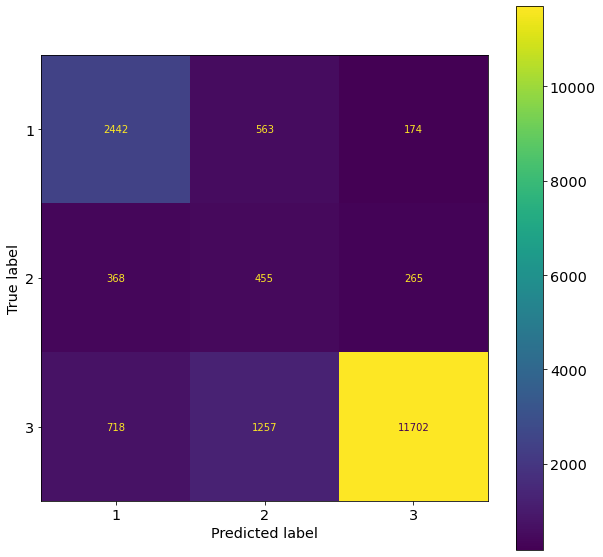

In [25]:
clf1 = LogisticRegression(multi_class="multinomial")
clf2 = MultinomialNB()

eclf3 = VotingClassifier(estimators=[('lr', clf1), ('mnb', clf2)], voting='hard', weights=[
                         2, 1], flatten_transform=True)

eclf3.fit(X_resampled, y_resampled)
predictions = eclf3.predict(X_test)
print("Cohen Kappa Score:", cohen_kappa_score(y_test, predictions) * 100)
print(classification_report(y_test, predictions))
print(classification_report_imbalanced(y_test, predictions))

cm = confusion_matrix(y_test, predictions, labels=eclf3.classes_)
fig, ax = plt.subplots(figsize=(10, 10))
disp = ConfusionMatrixDisplay(
    confusion_matrix=cm, display_labels=eclf3.classes_)
disp.plot(ax=ax)

plt.show()

##### 8.5.7.IMBENS: Class-imbalanced Ensemble Learning : [AsymBoostClassifier](https://imbalanced-ensemble.readthedocs.io/en/latest/api/ensemble/_autosummary/imbalanced_ensemble.ensemble.AsymBoostClassifier.html)

In [32]:
#!pip install imbalanced-ensemble

In [33]:
#!pip install --upgrade imbalanced_ensemble

Cohen Kappa Score: 46.13055984805923
              precision    recall  f1-score   support

           1       0.47      0.83      0.60      3179
           2       0.21      0.08      0.12      1088
           3       0.92      0.80      0.86     13677

    accuracy                           0.76     17944
   macro avg       0.53      0.57      0.53     17944
weighted avg       0.80      0.76      0.77     17944

                   pre       rec       spe        f1       geo       iba       sup

          1       0.47      0.83      0.80      0.60      0.81      0.66      3179
          2       0.21      0.08      0.98      0.12      0.28      0.07      1088
          3       0.92      0.80      0.79      0.86      0.80      0.63     13677

avg / total       0.80      0.76      0.80      0.77      0.77      0.60     17944



Visualizer evaluating model AsymBoostClassifier on dataset  training  :: 100%|█
Visualizer evaluating model AsymBoostClassifier on dataset validation :: 100%|█


Visualizer computing confusion matrices.. Finished!


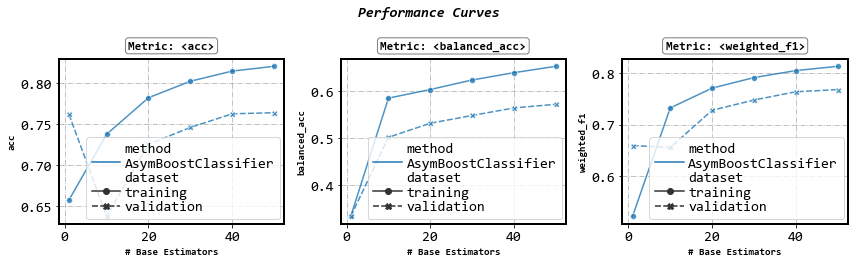

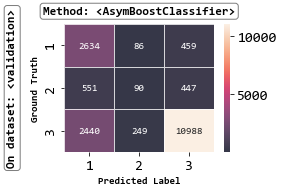

In [26]:
from imbalanced_ensemble.ensemble import AsymBoostClassifier
import imbalanced_ensemble as imbens

clf = AsymBoostClassifier(random_state=42)
clf.fit(X_train, y_train)
predictions = clf.predict(X_test)
print("Cohen Kappa Score:", cohen_kappa_score(y_test, predictions) * 100)
print(classification_report(y_test, predictions))
print(classification_report_imbalanced(y_test, predictions))

# cm = confusion_matrix(y_test, predictions, labels=clf.classes_)
# fig, ax = plt.subplots(figsize=(10, 10))
# disp = ConfusionMatrixDisplay(
#     confusion_matrix=cm, display_labels=clf.classes_)
# disp.plot(ax=ax)

# plt.show()

# Store the fitted AsymBoostClassifier
fitted_ensembles = {'AsymBoostClassifier': clf}

# Initialize visualizer
visualizer = imbens.visualizer.ImbalancedEnsembleVisualizer(
    eval_datasets = {
        'training' : (X_train, y_train),
        'validation' : (X_test, y_test),
    },
)

# Fit visualizer
visualizer.fit(fitted_ensembles)

fig, axes = visualizer.performance_lineplot()

fig, axes = visualizer.confusion_matrix_heatmap(
    on_datasets=['validation'], # only on validation set
    sup_title=False,
)

##### 8.5.8.IMBENS: Class-imbalanced Ensemble Learning: [AdaboostCost](https://imbalanced-ensemble.readthedocs.io/en/latest/api/ensemble/_autosummary/imbalanced_ensemble.ensemble.AdaCostClassifier.html)

Cohen Kappa Score: 27.699218093093812
              precision    recall  f1-score   support

           1       0.71      0.27      0.40      3179
           2       0.07      0.00      0.00      1088
           3       0.81      0.98      0.89     13677

    accuracy                           0.80     17944
   macro avg       0.53      0.42      0.43     17944
weighted avg       0.74      0.80      0.75     17944

                   pre       rec       spe        f1       geo       iba       sup

          1       0.71      0.27      0.98      0.40      0.52      0.25      3179
          2       0.07      0.00      1.00      0.00      0.03      0.00      1088
          3       0.81      0.98      0.24      0.89      0.49      0.25     13677

avg / total       0.74      0.80      0.42      0.75      0.46      0.24     17944



Visualizer evaluating model AdaCostClassifier on dataset  training  :: 100%|█| 
Visualizer evaluating model AdaCostClassifier on dataset validation :: 100%|█| 


Visualizer computing confusion matrices.. Finished!


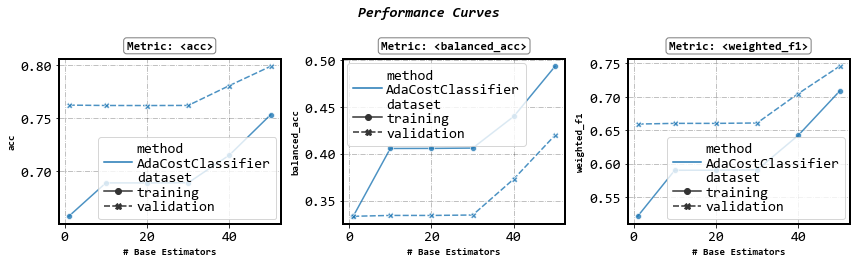

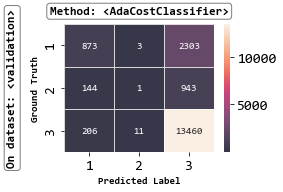

In [27]:
from imbalanced_ensemble.ensemble import AdaCostClassifier
clf = AdaCostClassifier(random_state=42)
clf.fit(X_train, y_train)
predictions = clf.predict(X_test)
print("Cohen Kappa Score:", cohen_kappa_score(y_test, predictions) * 100)
print(classification_report(y_test, predictions))
print(classification_report_imbalanced(y_test, predictions))

# cm = confusion_matrix(y_test, predictions, labels=clf.classes_)
# fig, ax = plt.subplots(figsize=(10, 10))
# disp = ConfusionMatrixDisplay(
#     confusion_matrix=cm, display_labels=clf.classes_)
# disp.plot(ax=ax)

# plt.show()

# Store the fitted AdaCostClassifier
fitted_ensembles = {'AdaCostClassifier': clf}

# Initialize visualizer
visualizer = imbens.visualizer.ImbalancedEnsembleVisualizer(
    eval_datasets = {
        'training' : (X_train, y_train),
        'validation' : (X_test, y_test),
    },
)

# Fit visualizer
visualizer.fit(fitted_ensembles)

fig, axes = visualizer.performance_lineplot()

fig, axes = visualizer.confusion_matrix_heatmap(
    on_datasets=['validation'], # only on validation set
    sup_title=False,
)

##### 8.5.9.Multiple OverSampling Ensemble : [SMOTEBoostClassifier](https://imbalanced-ensemble.readthedocs.io/en/latest/api/ensemble/_autosummary/imbalanced_ensemble.ensemble.SMOTEBoostClassifier.html)

Cohen Kappa Score: 42.76138590748172
              precision    recall  f1-score   support

           1       0.49      0.76      0.59      3179
           2       0.15      0.31      0.20      1088
           3       0.95      0.75      0.84     13677

    accuracy                           0.72     17944
   macro avg       0.53      0.60      0.54     17944
weighted avg       0.82      0.72      0.75     17944

                   pre       rec       spe        f1       geo       iba       sup

          1       0.49      0.76      0.83      0.59      0.79      0.62      3179
          2       0.15      0.31      0.89      0.20      0.52      0.26      1088
          3       0.95      0.75      0.86      0.84      0.80      0.64     13677

avg / total       0.82      0.72      0.86      0.75      0.78      0.61     17944



Visualizer evaluating model SMOTEBoostClassifier on dataset  training  :: 100%|
Visualizer evaluating model SMOTEBoostClassifier on dataset validation :: 100%|


Visualizer computing confusion matrices.. Finished!


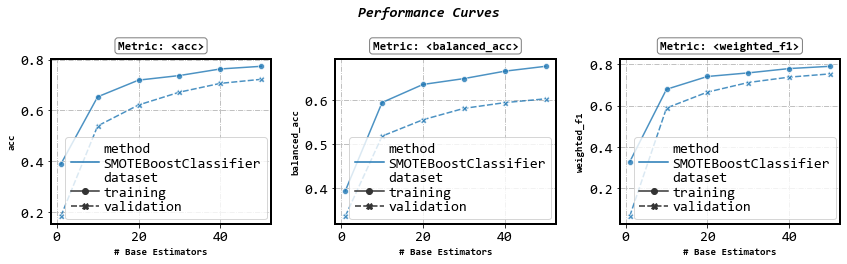

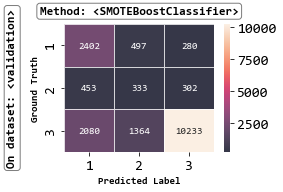

In [28]:
from imbalanced_ensemble.ensemble import SMOTEBoostClassifier
clf = SMOTEBoostClassifier(random_state=42)
clf.fit(X_train, y_train)
predictions = clf.predict(X_test)
print("Cohen Kappa Score:", cohen_kappa_score(y_test, predictions) * 100)
print(classification_report(y_test, predictions))
print(classification_report_imbalanced(y_test, predictions))

# cm = confusion_matrix(y_test, predictions, labels=clf.classes_)
# fig, ax = plt.subplots(figsize=(10, 10))
# disp = ConfusionMatrixDisplay(
#     confusion_matrix=cm, display_labels=clf.classes_)
# disp.plot(ax=ax)

# plt.show()

# Store the fitted SMOTEBoostClassifier
fitted_ensembles = {'SMOTEBoostClassifier': clf}

# Initialize visualizer
visualizer = imbens.visualizer.ImbalancedEnsembleVisualizer(
    eval_datasets = {
        'training' : (X_train, y_train),
        'validation' : (X_test, y_test),
    },
)

# Fit visualizer
visualizer.fit(fitted_ensembles)

fig, axes = visualizer.performance_lineplot()

fig, axes = visualizer.confusion_matrix_heatmap(
    on_datasets=['validation'], # only on validation set
    sup_title=False,
)

##### 8.5.10.Multiple OverSampling Ensemble : [SMOTEBaggingClassifier](https://imbalanced-ensemble.readthedocs.io/en/latest/api/ensemble/_autosummary/imbalanced_ensemble.ensemble.SMOTEBaggingClassifier.html)

Cohen Kappa Score: 56.85411151203682
              precision    recall  f1-score   support

           1       0.63      0.77      0.69      3179
           2       0.23      0.16      0.19      1088
           3       0.92      0.90      0.91     13677

    accuracy                           0.83     17944
   macro avg       0.59      0.61      0.60     17944
weighted avg       0.83      0.83      0.83     17944

                   pre       rec       spe        f1       geo       iba       sup

          1       0.63      0.77      0.90      0.69      0.83      0.69      3179
          2       0.23      0.16      0.96      0.19      0.40      0.15      1088
          3       0.92      0.90      0.76      0.91      0.83      0.69     13677

avg / total       0.83      0.83      0.80      0.83      0.80      0.66     17944



Visualizer evaluating model SMOTEBaggingClassifier on dataset  training  :: 100
Visualizer evaluating model SMOTEBaggingClassifier on dataset validation :: 100


Visualizer computing confusion matrices.. Finished!


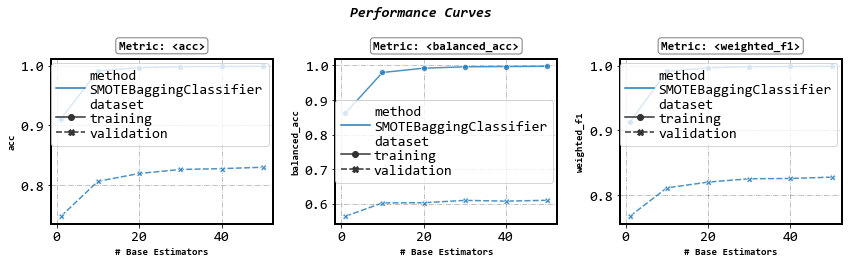

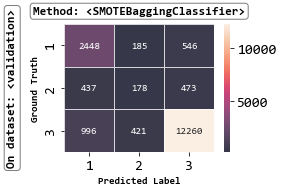

In [29]:
from imbalanced_ensemble.ensemble import SMOTEBaggingClassifier
clf = SMOTEBaggingClassifier(random_state=42)
clf.fit(X_train, y_train)
predictions = clf.predict(X_test)
print("Cohen Kappa Score:", cohen_kappa_score(y_test, predictions) * 100)
print(classification_report(y_test, predictions))
print(classification_report_imbalanced(y_test, predictions))

# cm = confusion_matrix(y_test, predictions, labels=clf.classes_)
# fig, ax = plt.subplots(figsize=(10, 10))
# disp = ConfusionMatrixDisplay(
#     confusion_matrix=cm, display_labels=clf.classes_)
# disp.plot(ax=ax)

# plt.show()

# Store the fitted SMOTEBaggingClassifier
fitted_ensembles = {'SMOTEBaggingClassifier': clf}

# Initialize visualizer
visualizer = imbens.visualizer.ImbalancedEnsembleVisualizer(
    eval_datasets = {
        'training' : (X_train, y_train),
        'validation' : (X_test, y_test),
    },
)

# Fit visualizer
visualizer.fit(fitted_ensembles)

fig, axes = visualizer.performance_lineplot()

fig, axes = visualizer.confusion_matrix_heatmap(
    on_datasets=['validation'], # only on validation set
    sup_title=False,
)